##### Copyright 2022 Jing Wang.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License. 

# This notebook is a modified version of https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb

# The original license is as follows:

# The MIT License (MIT)

# Copyright (c) 2016 Jacob VanderPlas

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Clustering
- 02 Dec 2022, COMP-1801 IT lab 10
$\newcommand{\Vec}[1]{\boldsymbol{#1}}$
$\newcommand{\Mat}[1]{\boldsymbol{#1}}$
## Aim
- Understand Python and Scikit-learn interfaces for clustering.
- Learn the algorithm of k-means
- Appendix: Experience applications of clustering
## Note: to execute a cell, press SHIFT + ENTER

## Import libraries
- matplotlib: for plotting
- NumPy: for vectors, matrices


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt # for plotting
import seaborn as sns; sns.set()  # for plot styling
import numpy as np # array library

# Introducing operations of clustering (including k-means, DBSCAN, spectral clustering, etc)


## Overview
- What to do: to obtain cluster label vector $\Vec{c}$ for data matrix $\Mat{X}$ **only from $\Mat{X}$** itself.
- We have no target values.
- We can use classes defined in the `sklearn.cluster` module.


## Initializer (e.g., `KMeans`): determining hyperparameters.
- Parameters (example):
  - $k$ (`n_clusters=k`): the number of clusters (for `KMeans`, `SpectralClustering`).

## Fit & predict (`model.fit_predict`): ${\Mat{X}} \mapsto \Vec{c} (, \Vec{\theta})$.
- Inputs: 
  - ${\Mat{X}}$ (`X`): the reference data matrix, the matrix (2D `np.ndarray`) that contains the data vectors. ${\Mat{X}} \in \mathbb{R}^{m, n}$ (`X.shape == (m, n)`).
    - $m$ (`m`): the number of the reference data points. $m \in \mathbb{N}$ (`type(m) == int`).
    - $n$ (`n`): the dimension of a data vector. $n \in \mathbb{N}$ (`type(n) == int`).
    - The $i$-th row $\Vec{x}^{(i) \top}$ (`X[i, :]`) of the data matrix ${\Mat{X}}$: the data vector (1D `np.ndarray`) of the $i$-th data point ($i = 0, 1, \dots, m-1$). $\Vec{x}^{(i) \top} \in \mathbb{R}^{n}$ (`X[i, :].shape == (n, )`).
$$
        \Mat{X}
        = \begin{bmatrix}
        \Vec{x}^{(0) \top} \\
        \Vec{x}^{(1) \top} \\
        \vdots \\
        \Vec{x}^{(m - 1) \top} \\
        \end{bmatrix}
        \in \mathbb{R}^{m, n}.
$$
- Implicit outputs (attributes to be stored):
  - ${\Vec{\theta}}$ (e.g. `model.components_`): the parameter vector that characterises the clusters. Some clustering methods do not have explicit parameters.

- Outputs:
  - $\Vec{c}$ (`c`): the cluster label vector, the vector (1D or 2D `np.ndarray`) that indicates the cluster of each data point. $\Vec{c} \in \mathbb{R}^{m}$ (`c.shape == (m, )`).
    - The $i$-th element ${c}^{(i)}$ (`c[i]`) of $\Vec{c}$: 
the cluster label (`int`) of the $i$-th new data point (${c}^{(i)} = 1, 2, \dots, k-1$, $i = 0, 1, \dots, m-1$).
$$
      \Vec{c}
      = \begin{bmatrix}
      {c}^{(0)} \\
      {c}^{(1)} \\
      \vdots \\
      {c}^{(m - 1)} \\
      \end{bmatrix}
      \in \mathbb{R}^{m}.
$$
    - $k$ (`k`): the number of clusters. $k \in \mathbb{N}$ (`type(k) == int`).


# K-means
K-means partitions $m$ data points $\Vec{x}^{(0)}, \Vec{x}^{(1)}, \dots, \Vec{x}^{(m-1)} \in \mathbb{R}^{n}$ to $k$ clusters, each of which has its own *cluster center (centroid)*. Each data point belongs to the cluster that has the nearest centroid. We can implement it by a `sklearn.cluster.KMeans` instance.
- The parameters $\Vec{\theta}$ consist of the centroid matrix $\Mat{M} \in \mathbb{R}^{k, n}$ (`model.cluster_centers_`):
$$
  \Mat{M}
  = \begin{bmatrix}
  \Vec{\mu}^{[0] \top} \\
  \Vec{\mu}^{[1] \top} \\
  \vdots \\
  \Vec{\mu}^{[k-1] \top} \\
  \end{bmatrix}
  \in \mathbb{R}^{k, n},
$$

 where the $l$-th row $\Vec{\mu}^{[l] \top} \in \mathbb{R}^{n}$ (`model.cluster_centers_[l, :]`) of $\Mat{M}$ is the centroid of the $l$-th cluster.



## Cost function
$$J = \sum_{i=0}^{m-1} \left\| \Vec{x}^{(i)} - \Vec{\mu}^{[c^{(i)}]} \right\|^{2}.$$
We are going to minimize $J$ with respect to centroid matrix $\Mat{M}$ and cluster label vector $\Vec{c}$.


## Algorithm
- Update the cluster label of each data point with the cluster that has the nearest centroid to the data point.
$$
\begin{eqnarray} 
c^{(i)} &\gets& \mathop{\mathrm{argmin}}_{\ell = 0,1,\dots,k-1} \left\| \Vec{x}^{(i)} - \Vec{\mu}^{[\ell]} \right\|^2,
&\textrm{for } i = 0, 1, \dots, m-1.
\begin{aligned} 
\end{aligned}
\end{eqnarray}
$$

- Update the centroid of each cluster with the arithmetric mean of the data points that belongs to the cluster.
$$ \Vec{\mu}^{[\ell]} \gets \frac{\sum_{i: c^{(i)} = l} \Vec{x}^{(i)}}{\sum_{i: c^{(i)} = l} 1}, \textrm{for } \ell = 0, 1, \dots, k-1.$$



## `sklearn` interfaces
- We specify the number $k$ of clusters by the `n_clusters` parameter of the initializer of the `sklearn.clusters.KMeans` class.
- Fit and predict (`model.fit_predict` method): ${\Mat{X}} \mapsto \Vec{c} (, (\Vec{\mu}^{[l] \top})_{l=0}^{k-1})$.


#  Now let's implement k-means on dataset!



# Dataset 1: Toy dataset

## Creating a toy dataset
- The number of data points: $m=300$.
- The dimensionality of each data point: $n=2$.

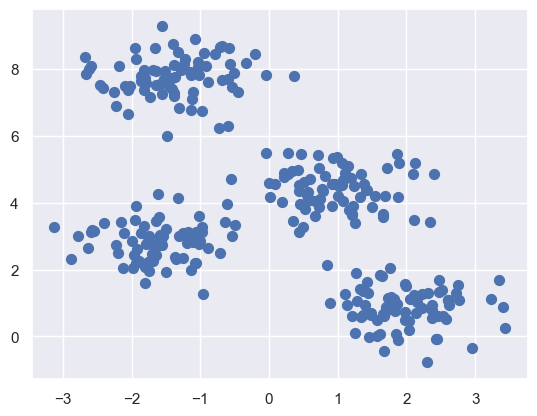

In [1]:
from sklearn.datasets import make_blobs # To create a toy dataset
import matplotlib.pyplot as plt # A library to draw a scatter plot 
import seaborn as sns 
sns.set() # For a more sophisticated plot style.

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [3]:
X

array([[ 8.36856841e-01,  2.13635938e+00],
       [-1.41365810e+00,  7.40962324e+00],
       [ 1.15521298e+00,  5.09961887e+00],
       [-1.01861632e+00,  7.81491465e+00],
       [ 1.27135141e+00,  1.89254207e+00],
       [ 3.43761754e+00,  2.61654166e-01],
       [-1.80822253e+00,  1.59701749e+00],
       [ 1.41372442e+00,  4.38117707e+00],
       [-2.04932168e-01,  8.43209665e+00],
       [-7.11099611e-01,  8.66043846e+00],
       [-1.71237268e+00,  2.77780226e+00],
       [-2.67000792e+00,  8.35389140e+00],
       [ 1.24258802e+00,  4.50399192e+00],
       [-2.22783649e+00,  6.89479938e+00],
       [ 1.45513831e+00, -2.91989981e-02],
       [ 4.53791789e-01,  3.95647753e+00],
       [ 1.06923853e+00,  4.53068484e+00],
       [ 2.56936589e+00,  5.07048304e-01],
       [-1.06690610e+00,  3.13165795e+00],
       [-1.07859101e+00,  2.20451529e+00],
       [ 2.71506328e+00,  1.29082190e+00],
       [ 1.77710994e+00,  1.18655254e+00],
       [ 7.34363910e-01,  5.03725437e+00],
       [-1.

## Implementation


### Initializer
- We set the number of clusters $k=4$ by specifying `n_clusters=4` in the initializer of the `KMeans` class.

In [5]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=4)

### Fit and predict

In [6]:
cluster_labels = model.fit_predict(X)

C:\Users\abume\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Access the clustering result
- Cluster label vector $\Vec{c} \in \mathbb{R}^{m}$ (the return value of the `model.fit_predict` method).

In [7]:
display(cluster_labels) #show clustering results of each datapoint

array([2, 1, 3, 1, 2, 2, 0, 3, 1, 1, 0, 1, 3, 1, 2, 3, 3, 2, 0, 0, 2, 2,
       3, 0, 0, 3, 2, 3, 0, 3, 1, 1, 3, 1, 1, 1, 1, 1, 0, 2, 3, 0, 3, 3,
       0, 0, 1, 0, 1, 2, 0, 2, 1, 2, 2, 0, 1, 0, 1, 2, 1, 3, 1, 0, 0, 0,
       1, 2, 1, 0, 3, 0, 1, 0, 0, 1, 0, 3, 2, 1, 2, 3, 2, 2, 1, 3, 2, 3,
       1, 1, 3, 2, 1, 0, 0, 3, 2, 2, 3, 0, 1, 2, 1, 2, 3, 2, 2, 3, 1, 3,
       0, 0, 2, 1, 2, 3, 1, 2, 2, 3, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 1, 0,
       0, 2, 1, 0, 0, 1, 3, 1, 1, 0, 3, 0, 3, 0, 1, 3, 1, 1, 1, 3, 1, 3,
       2, 0, 1, 0, 2, 3, 1, 3, 3, 2, 3, 0, 0, 3, 2, 3, 3, 1, 2, 3, 0, 1,
       2, 2, 3, 0, 2, 3, 0, 0, 3, 3, 3, 3, 2, 1, 3, 0, 3, 3, 0, 0, 0, 3,
       0, 1, 3, 0, 2, 0, 3, 1, 0, 1, 3, 1, 3, 0, 3, 3, 1, 0, 0, 2, 2, 3,
       1, 2, 2, 0, 2, 0, 3, 1, 1, 3, 3, 1, 3, 2, 0, 3, 2, 0, 1, 0, 2, 3,
       2, 1, 1, 1, 1, 0, 0, 1, 3, 0, 2, 3, 0, 0, 0, 2, 2, 1, 3, 3, 0, 2,
       1, 0, 3, 1, 3, 2, 2, 0, 0, 3, 2, 2, 2, 3, 1, 1, 2, 2, 3, 2, 2, 2,
       1, 0, 1, 3, 2, 2, 1, 1, 1, 2, 2, 3, 1, 0])

- Cluster center matrix $\Mat{M} \in \mathbb{R}^{k, n}$ (the `model.cluster_centers_` attribute).

In [8]:
display(model.cluster_centers_) #display cluster centriods

array([[-1.58438467,  2.83081263],
       [-1.37324398,  7.75368871],
       [ 1.98258281,  0.86771314],
       [ 0.94973532,  4.41906906]])

## Plot the clustering results
- The colour indicates the cluster label of each data point.

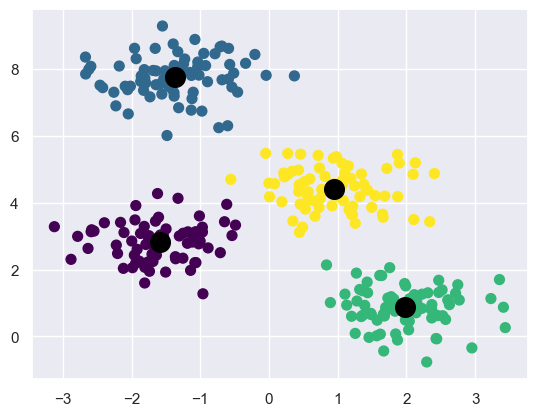

In [9]:
import matplotlib.pyplot as plt # A library to draw a scatter plot 
import seaborn as sns 
sns.set() # For a more sophisticated plot style.

plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, s=50, cmap='viridis')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c='black', s=200);

## **Exercise 1**: Using K-means to cluster dataset into 6 clusters (MODIFY CODE)
- Specify $k = 6$ by setting `n_clusters=6` in the initializer of the `KMeans` class.

In [10]:
from sklearn.cluster import KMeans

# Partition the data into 6 clusters using k-means
# Define the following variables:
#   model: KMeans instance.
#   labels: Cluster label vector. 1D np.array with shape of (m, ).


  # Modify the code: start 
  ##############################
model = KMeans(n_clusters=6)
cluster_labels = model.fit_predict(X)
  ##############################

  # Modify the code: end

C:\Users\abume\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


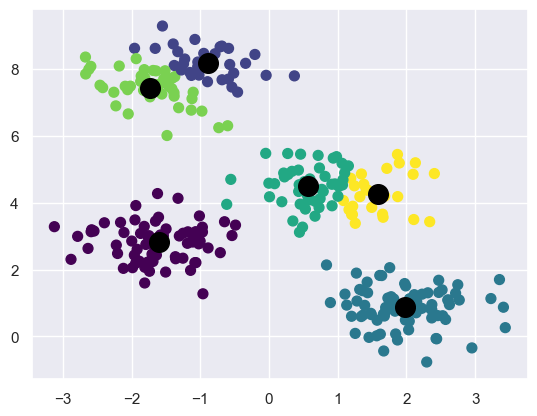

In [11]:
import matplotlib.pyplot as plt # A library to draw a scatter plot 
import seaborn as sns 
sns.set() # For a more sophisticated plot style.

plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, s=50, cmap='viridis')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c='black', s=200);

#  Great, you have successfully implemented k-means. Now let's implement both k-means and agglomerative clustering on another dataset!

# Dataset 2: Moon shape dataset

## Creating a moon shape dataset

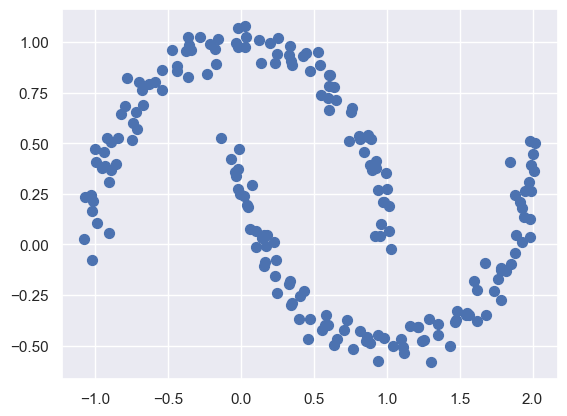

In [12]:
from sklearn.datasets import make_moons # To create a moon shape dataset
X, y = make_moons(200, noise=.05, random_state=0)
import matplotlib.pyplot as plt # A library to draw a scatter plot 
import seaborn as sns 
sns.set() # For a more sophisticated plot style.

plt.scatter(X[:, 0], X[:, 1], s=50);

## Implementation of K-means
## **Exercise 2**: Applying K-means to the dataset (MODIFY CODES)
- Based on the data distribution, could you please specify the number of clusters k? 
- Then applying k-means to cluster the dataset into k clusters, and produce silhoette_score. 

C:\Users\abume\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.49215648268306905
Hopefully, you can get silhouette_score around 0.49


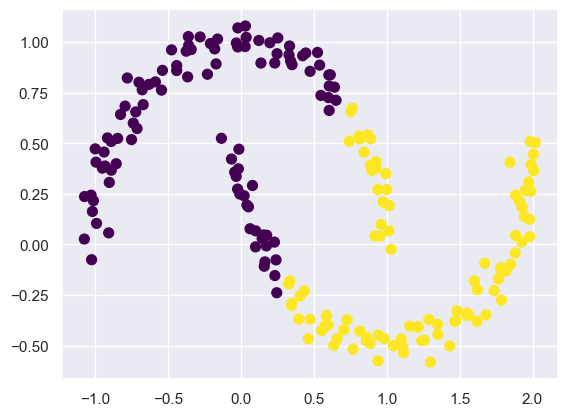

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt # A library to draw a scatter plot 
import seaborn as sns 

sns.set() # For a more sophisticated plot style.
  # Modify the code: start 
  ##############################
from sklearn.metrics import silhouette_score
model = KMeans(n_clusters=2, random_state=0)
cluster_labels = model.fit_predict(X)
print(silhouette_score(X, cluster_labels))
  ##############################
  # Modify the code: end
print('Hopefully, you can get silhouette_score around 0.49')
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, s=50, cmap='viridis');

###**Question: Is the result clustered by K-means perfect? And Why?**

### Answer: No, because the clustering results does not fit the moon shape

## Implementation of agglomerative clustering





## **Exercise 3**: Applying agglomerative (hierarchical) clustering to the dataset (MODIFY CODES)
- Applying `AgglomerativeClustering`, and produce silhoette_score.
- Specify `n_clusters=k (where you have specified for k-means)`, since we need to compare the performance of the two methods so the number of clusters should be set to be the same for fair comparison. 
- The `linkage='single'` option. In this way, we use the distance of the nearest pair to define the distance between two clusters. 
- Specify `compute_distances=True` to record the distance of pairs of clusters agglomerative during the clustering procedure. The distance information will be used to draw the dendrogram figure. 

0.32585318950197517
Hopefully, you can get silhouette_score around 0.33


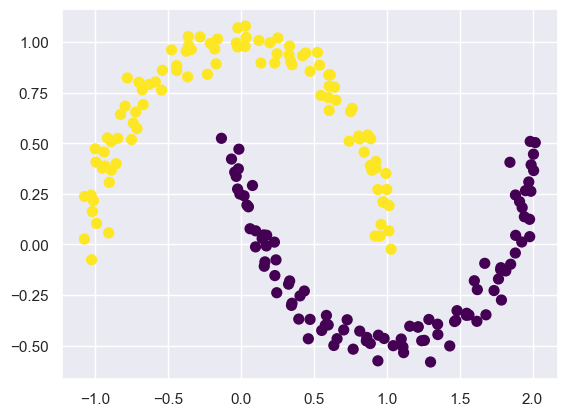

In [15]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt # A library to draw a scatter plot 
import seaborn as sns 
sns.set() # For a more sophisticated plot style.


  # Modify the code: start 
  ##############################
from sklearn.metrics import silhouette_score
model = AgglomerativeClustering(n_clusters=2, linkage='single', compute_distances=True)
cluster_labels = model.fit_predict(X)
print(silhouette_score(X, cluster_labels))
  ##############################
  # Modify the code: end

print('Hopefully, you can get silhouette_score around 0.33')
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, s=50, cmap='viridis');



###**Question: From silhouette score,  aggolomerative clustering perform worse than k-means, does it mean result clustered by agglomerative clustering worse than that of K-means? And Why?** 


### Answer: No, agglomerative clustering performs better since the clustering results fit the moon shape. The silhouette score cannot measure whether the clustering results fit the moon shape or not. In this case, we can use external evaluation metrics if we have labels.

## Plot the hierarchical clustering dendrogram.
By plotting the dendrogram, we can see how the algorithm agglomerated the points.

The following code is modified from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py (licensed by the modified BSD license).

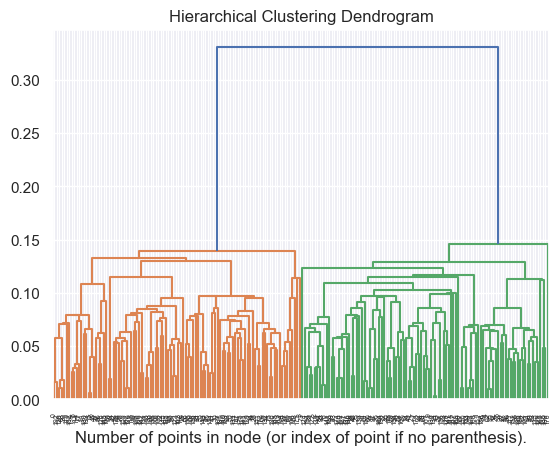

In [21]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.
plt.show()


# We have applied clustering on synthetic datasets, now we will apply clustering on real word applications.


# Application 1: clustering hand-written digit images

## Load and display the dataset

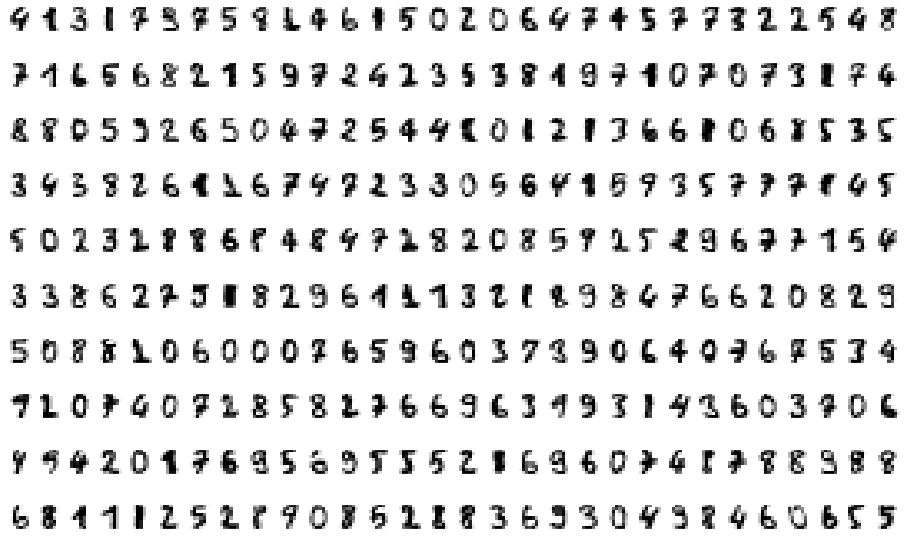

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
#print(X.shape)

from numpy.random import default_rng
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

rng = default_rng(0)
n_rows = 10
n_cols = 30
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, 10))
random_digits = X[rng.choice(X.shape[0], size = n_rows * n_cols, replace=False)]
for axi, center in zip(ax.flat, random_digits.reshape(-1, 8, 8)):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)
fig.show()

## Applying the k-means algorithm
- The number of clusters: $k=10$.

In [22]:
from sklearn.cluster import KMeans
n_clusters=10
model = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = model.fit_predict(X)

C:\Users\abume\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Displaying the clustering results


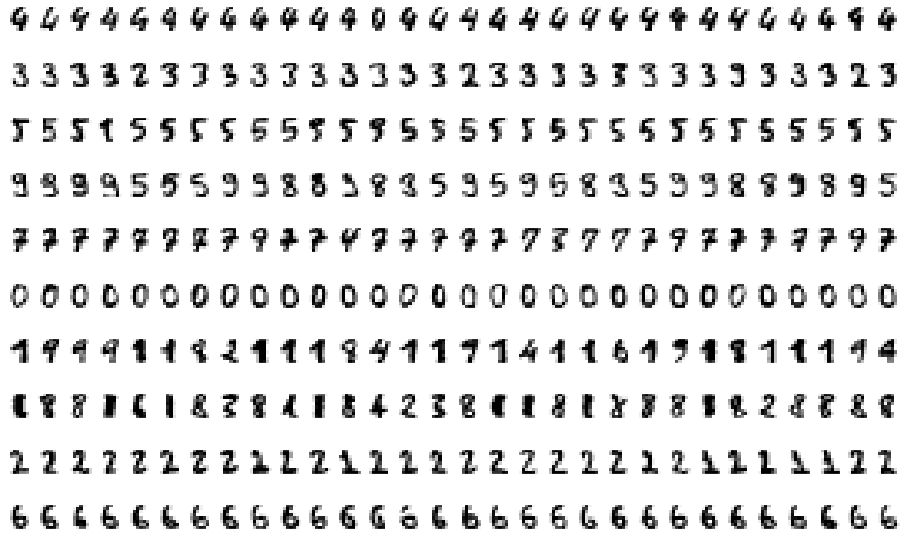

In [ ]:
from numpy.random import default_rng
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

rng = default_rng(0)
n_rows = 10
n_cols = 30
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, 10))
digit_clusters = [X[cluster_labels==i_cluster] for i_cluster in range(n_clusters)] 
for ax_row, digit_cluster in zip(ax, digit_clusters):
  for axi, digit_data in zip(ax_row, digit_cluster[rng.choice(digit_cluster.shape[0], n_cols, replace=False)]):
    axi.set(xticks=[], yticks=[])
    axi.imshow(digit_data.reshape(8, 8), interpolation='nearest', cmap=plt.cm.binary)
fig.show()

Here, each row indicates the images in a cluster. Although the model did not have information regarding which digit is written in each image, the clustering results almost in accordance with the digit written in each image. This result shows the power of unsupervised learning. 

## **Exercise 4**:Evaluate the clustering results using labels (MODIFY CODES)
We assume each digit corresponding to each label, e.g., digit number '1' is label 1.
- we can use the adjusted Rand index (ARI) score (`sklearn.metrics.adjusted_rand_score` function) and Normalized Mutual Information (NMI) score (`sklearn.metrics.normalized_mutual_info_score` function). 
  - ARI takes a value between 0 and 1, where the value equals to 1 only if a partition is completely identical to the intrinsic structure and close to 0 for a random partition.
  - NMI is a normalization of the Mutual Information (MI) score to scale the results between 0 (no mutual information) and 1 (perfect correlation).


In [ ]:
true_cluster_labels = digits.target
  # Modify the code: start
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
print(adjusted_rand_score(true_cluster_labels, cluster_labels))
print(normalized_mutual_info_score (true_cluster_labels, cluster_labels))
  # Modify the code: end 
print('Hopefully you can get ARI is around 0.67 and NMI is around 0.75')

0.7940031835568753
0.8681701126909084
Hopefully you can get ARI is around 0.67 and NMI is around 0.75


## **Exercise 5**: Applying agglomerative clustering (IMPLEMENTATION BY YOURSELF)
###Implement aggolomerative clustering and produce ARI and NMI score.
- You can use the `AgglomerativeClustering` class in the `sklearn.cluster` module.
- Specify $k=10$ (`n_clusters=10`) in the constructor (`AgglomerativeClustering`).

In [ ]:
  # Implementation: start
  ##############################
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=10)
cluster_labels = model.fit_predict(X)

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
true_cluster_labels = digits.target
print(adjusted_rand_score(true_cluster_labels, cluster_labels))
print(normalized_mutual_info_score (true_cluster_labels, cluster_labels))
  ##############################
  # Implementation: end
print('Hopefully you can get ARI is around 0.79 and NMI is around 0.87')

# Application 2: Image data compression


## Load and display the dataset


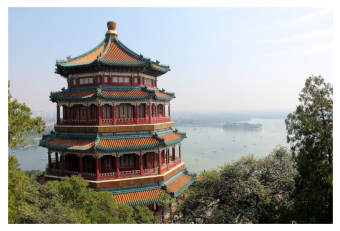

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);
fig.show()

## Plotting pixels in the RGB colour space

In [ ]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20)
    return fig

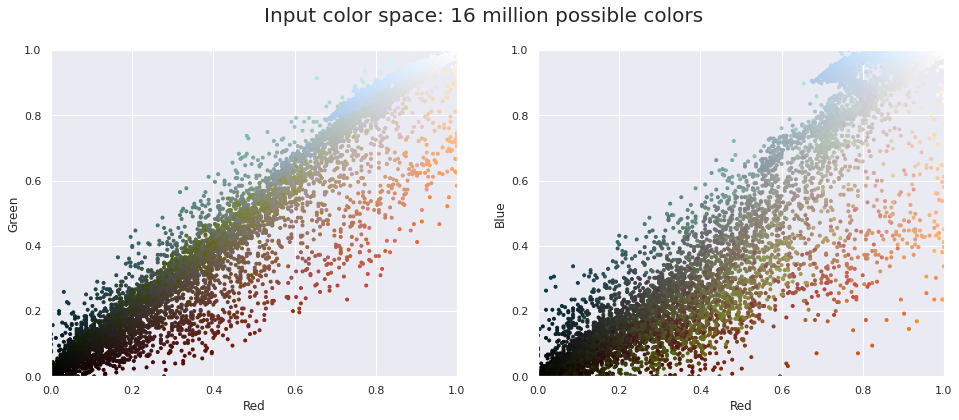

In [ ]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
fig = plot_pixels(data, title='Input color space: 16 million possible colors')
fig.show()


## Plotting pixels with 16 colours
- We apply the (mini-batch) k-means and partition the data into 16 clusters.
  - We use the mini-batch version to reduce the computational cost.
- We substitute each colour with its nearest centroid's colour.

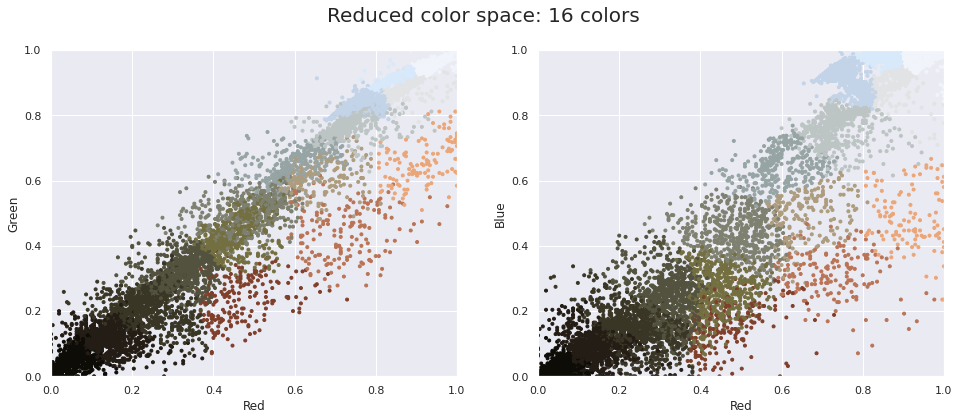

In [ ]:
from sklearn.cluster import MiniBatchKMeans
model = MiniBatchKMeans(n_clusters=16)
model.fit(data)
new_colors = model.cluster_centers_[model.predict(data)]

fig = plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")
fig.show()

- We substitute each colour with its nearest centroid's colour. 

## Displaying the recoloured image with 16 colours.

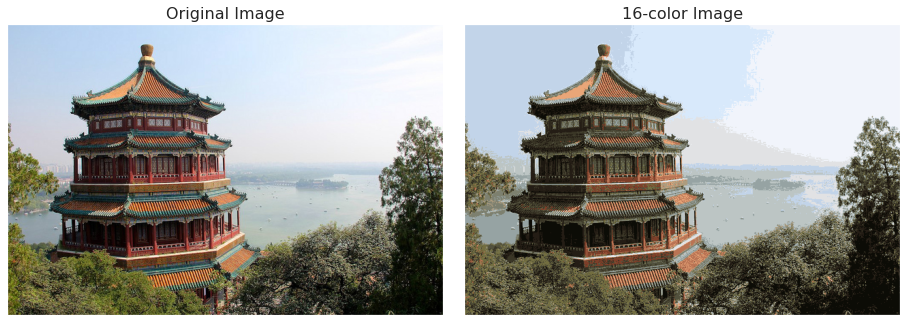

In [ ]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);
fig.show()

## Now, displaying the recoloured image with only 4 colours.
- Change the number of clusters by specify $k=4$.

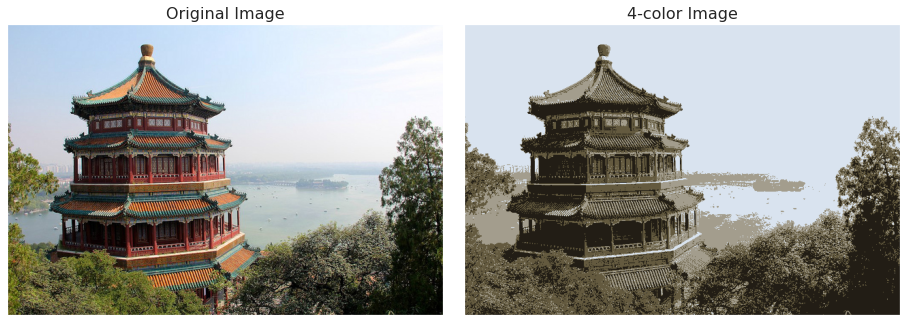

In [ ]:
from sklearn.cluster import MiniBatchKMeans
model = MiniBatchKMeans(n_clusters=4) # you can change the number of clusters here
model.fit(data)
new_colors = model.cluster_centers_[model.predict(data)]

china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('4-color Image', size=16);
fig.show()

### **Question: Discuss the advantages of increasing/decreasing number of clusters.**

### Answer: if increase the number of clusters, we can reproduce the original image in higher precision, but if decrease the number of clusters, we can achieve higher compression ratio.